In [1]:
import os
from tensorflow import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
dataset_path = '/content/drive/MyDrive/train'
print(os.listdir(dataset_path))


['NORMAL', 'PNEUMONIA']


In [5]:

images = []
labels = []

for subfolder in os.listdir(dataset_path):

    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        labels.append(subfolder)

df = pd.DataFrame({'image': images, 'label': labels})
df.head()

,image,label
0,/content/drive/MyDrive/train/NORMAL/IM-0536-00...,NORMAL
1,/content/drive/MyDrive/train/NORMAL/IM-0523-00...,NORMAL
2,/content/drive/MyDrive/train/NORMAL/IM-0531-00...,NORMAL
3,/content/drive/MyDrive/train/NORMAL/IM-0523-00...,NORMAL
4,/content/drive/MyDrive/train/NORMAL/IM-0537-00...,NORMAL


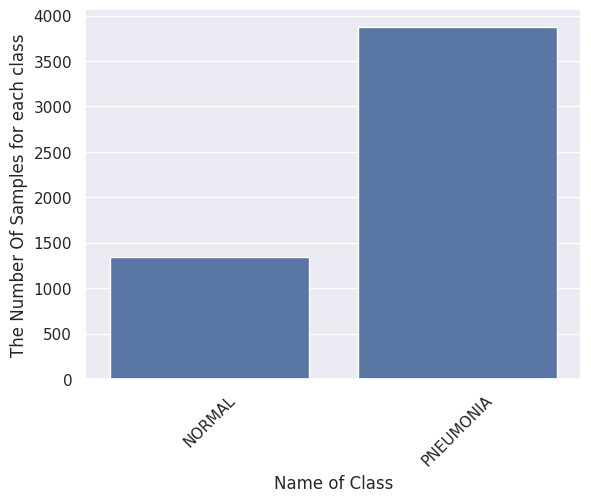

In [6]:
ax = sns.countplot(x=df.label)

ax.set_xlabel("Name of Class")
ax.set_ylabel("The Number Of Samples for each class")

plt.xticks(rotation=45)

plt.show()

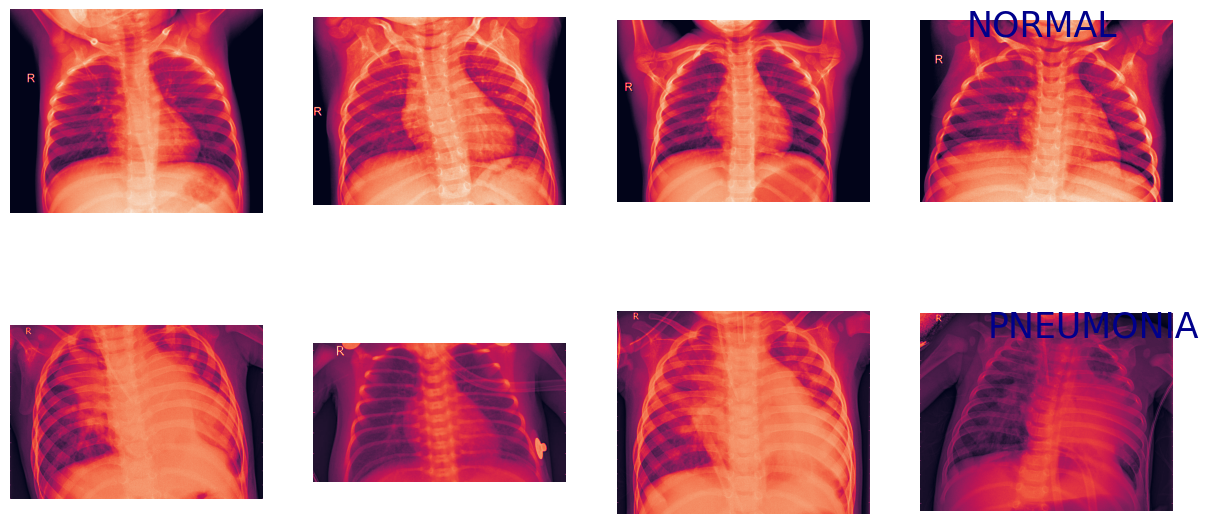

In [7]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(4, 4, figure=fig)

for i, category in enumerate(df['label'].unique()):
    filepaths = df[df['label'] == category]['image'].values[:4]

    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')

    ax.text(300, 100, category, fontsize=25, color='darkblue')

plt.show()

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['image'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']  # Menjaga distribusi label
)

df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})


In [9]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)


In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 1.9440820130475303, 1: 0.6731203614069055}


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (256, 256)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.


In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

model=Sequential()
model.add(Conv2D(256,(3,3),activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         401,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 925,090 (3.53 MB)

 Trainable params: 925,090 (3.53 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1552s 11s/step - accuracy: 0.6125 - loss: 0.6379 - val_accuracy: 0.8602 - val_loss: 0.3198 - learning_rate: 1.0000e-04
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.8307 - loss: 0.3632 - val_accuracy: 0.8075 - val_loss: 0.3890 - learning_rate: 1.0000e-04
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8283 - loss: 0.3634 - val_accuracy: 0.8736 - val_loss: 0.2715 - learning_rate: 1.0000e-04
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.8421 - loss: 0.3382 - val_accuracy: 0.8994 - val_loss: 0.2550 - learning_rate: 1.0000e-04
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.8645 - loss: 0.3120 - val_accuracy: 0.8602 - val_loss: 0.2981 - learning_rate: 1.0000e-04
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8674 - loss: 0.2971 - val_accuracy: 0.8831 - val_loss: 0.2555 - learning_rate: 1.0000e-04
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - a

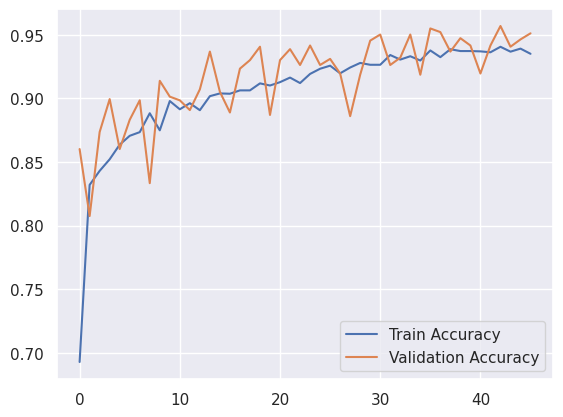

In [14]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

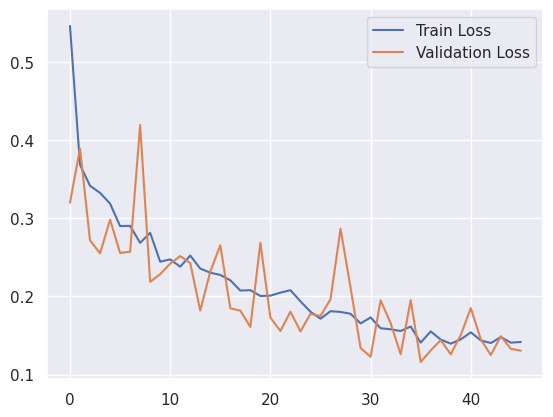

In [15]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()


In [16]:
model.evaluate(test_generator)

33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 940ms/step - accuracy: 0.9436 - loss: 0.1415


[0.1367902308702469, 0.946360170841217]

In [17]:
model.evaluate(train_generator)

131/131 ━━━━━━━━━━━━━━━━━━━━ 119s 900ms/step - accuracy: 0.9462 - loss: 0.1456


[0.13840928673744202, 0.9455896615982056]

33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 766ms/step


<Figure size 1000x800 with 0 Axes>

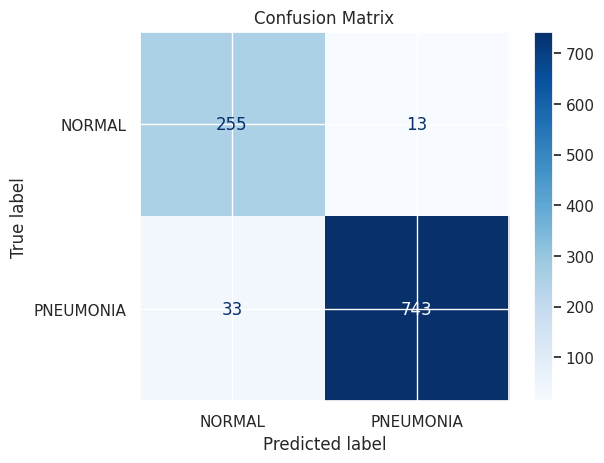

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.89      0.95      0.92       268
   PNEUMONIA       0.98      0.96      0.97       776

    accuracy                           0.96      1044
   macro avg       0.93      0.95      0.94      1044
weighted avg       0.96      0.96      0.96      1044



In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Konversi probabilitas menjadi kelas

y_true = test_generator.classes

y_true_decoded = encoder.inverse_transform(y_true)
y_pred_decoded = encoder.inverse_transform(y_pred_classes)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_true_decoded, y_pred_decoded, target_names=encoder.classes_))

In [19]:
model.save('/content/drive/MyDrive/modelfixpneumonia.keras')

In [20]:
import tensorflow as tf

model_path = '/content/drive/MyDrive/modelfixpneumonia.keras'

tflite_model_path = '/content/drive/MyDrive/modelfixpneumonia.tflite'

model = tf.keras.models.load_model(model_path)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpn3n7gjvw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134720243232160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720241970768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720242141312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720242147824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720242155216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720242154336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720240542720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720240534272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720240546064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720240766816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720240549056